# Differential Evolution

In this section, Differential Evolution (DE) algorithm is demonstrated. DE is a population-based stochastic optimization algorithm which updates population members by randomly mixing them, refer lecture notes for more details. It was proposed by Storn and Price in 1997. [Jones function](intro:jones-function) will be used to demonstrate the method. Following block imports all required packages:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Below block of code defines required `problem` and `algorithm`. Refer pymoo's [DE](https://pymoo.org/algorithms/soo/de.html) documentation for more details.

> **_NOTE_**: Performance of DE is highly dependent on its parameters such as population size, mixing strategy, crossover constant (also known as recombination (CR)) and weighting factor (also known as mutation (F)). The value for these parameters is problem specific and needs to be tuned for each problem.

In [15]:
class JonesFunction(Problem):
    """
        Class for Jones function
    """

    def __init__(self):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=np.array([-2, -2]), xu=np.array([4, 4]))

    def _evaluate(self, x, out, *args, **kwargs):

        x1 = x[:, 0]
        x2 = x[:, 1]

        out["F"] = x1**4 + x2**4 - 4*x1**3 - 3*x2**3 + 2*x1**2 + 2*x1*x2

problem = JonesFunction()

pop_size = 10 * problem.n_var # Number of individuals in the population: 10 times number of variables
sampling = LHS() # How the initial population is sampled

algorithm = DE(pop_size=pop_size, sampling=sampling, variant="DE/best/1/bin",
                CR=0.8, dither="vector")

Below block of code defines termination criteria and performs optimization:

In [16]:
termination = DefaultSingleObjectiveTermination(
    xtol=1e-3,
    cvtol=1e-3,
    ftol=1e-3,
    period=10,
    n_max_gen=1000,
    n_max_evals=100000
)

res = minimize(problem, algorithm, termination=termination, verbose=False, 
               save_history=True, seed=1)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [ 2.67331811 -0.67592461]
F = [-13.53203462]


DE is able to get to the global optimum. You can change the termination criteria or DE settings (such as CR or F) to see how the algorithm’s performance changes. The minimize function also returns an object of Result class which contains all the information about optimization, refer pymoo’s [result](https://pymoo.org/interface/result.html) documentation to see what all information is available.

Below block of code uses `res` variable to plot the variation of best, mean, and worst function value in the population over generations:

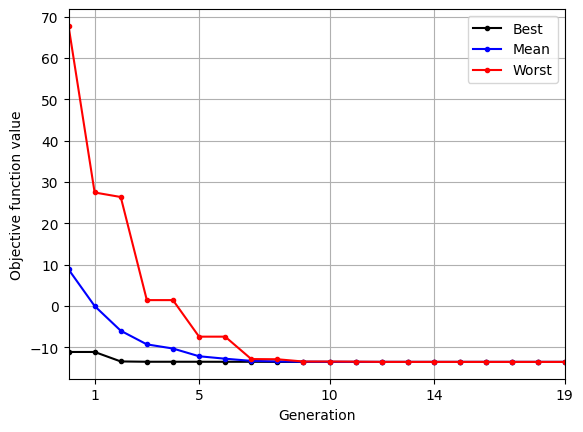

In [17]:
niter = len(res.history) # Number of iterations
iterations = np.linspace(0, niter-1, niter, dtype=np.int32) # Iteration vector
fbest = np.zeros(niter) # Vector to store the best fitness value at each iteration
fmean = np.zeros(niter) # Vector to store the mean fitness value at each iteration
fworst = np.zeros(niter) # Vector to store the worst fitness value at each iteration

for itr in iterations:
    f = res.history[itr].pop.get("F")
    fbest[itr] = np.min(f)
    fmean[itr] = np.mean(f)
    fworst[itr] = np.max(f)

# Plotting the convergence curve
fig, ax = plt.subplots()
ax.plot(iterations, fbest, "k", marker=".", label='Best')
ax.plot(iterations, fmean, "b", marker=".", label='Mean')
ax.plot(iterations, fworst, "r", marker=".", label='Worst')
ax.set_xlabel('Generation')
ax.set_ylabel('Objective function value')
ax.set_xticks(np.linspace(1, niter-1, 5, dtype=np.int32))
ax.set_xlim(left=0, right=niter-1)
ax.legend()
ax.grid()

As the population evolves, the best, mean, and worst function values in the population converge.

Below block of code defines a plotting function and uses `res` variable to visualize the evolution of population as optimization progresses:

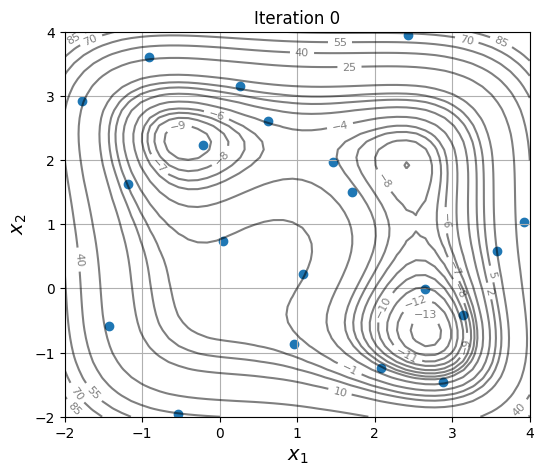

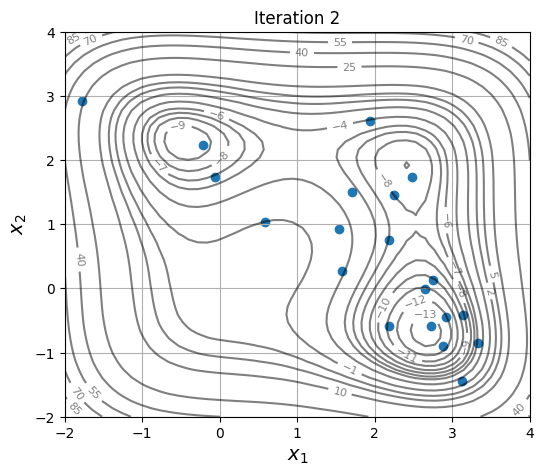

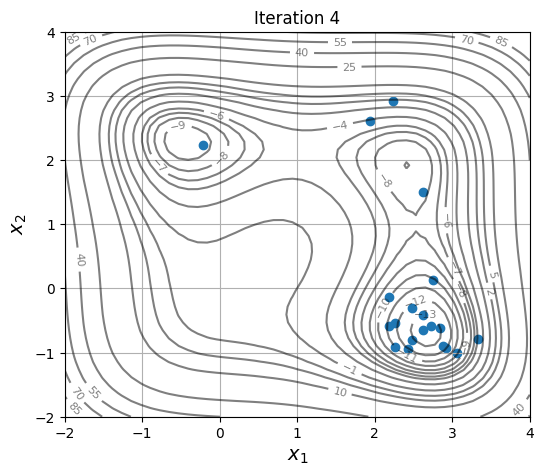

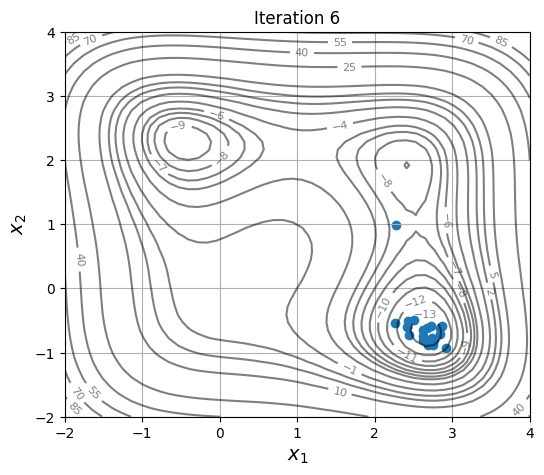

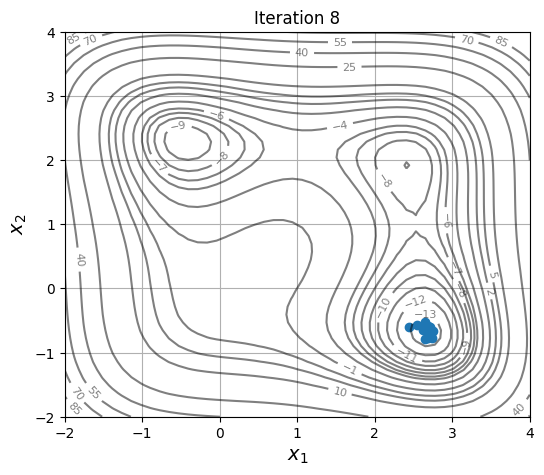

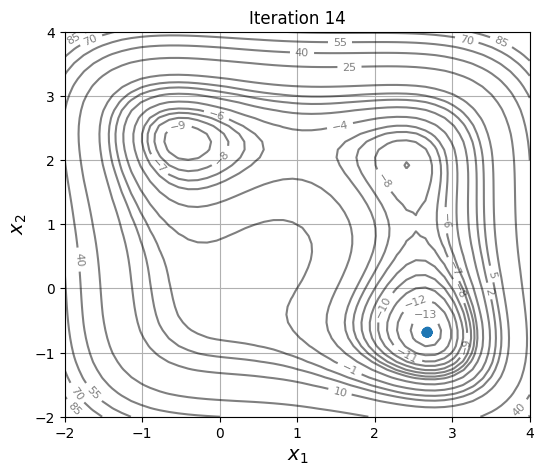

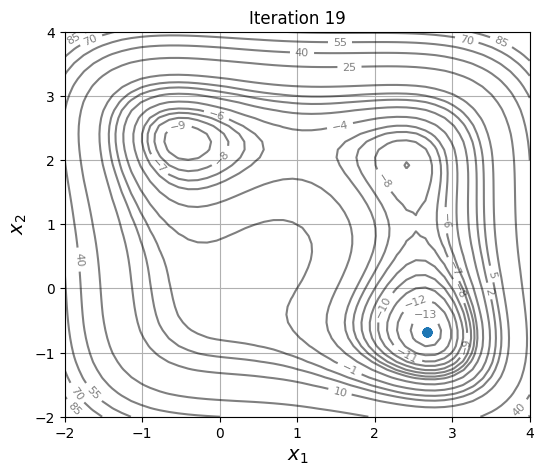

In [18]:
def plot_jones_function(ax=None):
    """
        Function which plots the jones function

        Input:
        ax (optional) - matplotlib axis object. If not provided, a new figure is created

        Returns ax object containing jones function plot
    """

    num_points = 50

    # Defining x and y values
    x = np.linspace(-2,4,num_points)
    y = np.linspace(-2,4,num_points)

    # Creating a mesh at which values will be evaluated and plotted
    X, Y = np.meshgrid(x, y)

    # Evaluating the function values at meshpoints
    out = {}
    Z = problem._evaluate(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))), out)
    Z = out["F"].reshape(num_points,num_points)

    # Denoting at which level to add contour lines
    levels = np.arange(-13,-5,1)
    levels = np.concatenate((levels, np.arange(-4, 8, 3)))
    levels = np.concatenate((levels, np.arange(10, 100, 15)))

    # Plotting the contours
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    CS = ax.contour(X, Y, Z, levels=levels, colors="k", linestyles="solid", alpha=0.5)
    ax.clabel(CS, inline=1, fontsize=8)
    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$x_2$", fontsize=14)
    ax.set_title("Jones Function", fontsize=14)

    return ax

niter = len(res.history) # Number of iterations
iterations = np.linspace(0, 8, 5, dtype=np.int32) # Array of iterations
iterations = np.concatenate(( iterations, np.array([14, niter-1]) )) # Adding the last iteration

# Plotting the particle evolution
for itr in iterations:
    ax = plot_jones_function()
    ax.scatter(res.history[itr].pop.get("X")[:, 0], res.history[itr].pop.get("X")[:, 1])
    ax.set_title("Iteration %s" % itr)
    ax.grid()
    ax.set_xlim([-2, 4])
    ax.set_ylim([-2, 4])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

As the members are updated, the population becomes more and more concentrated around the global optimum.